# Trabajo Final B.  De clasificación a NER

En este trabajo final utilizarán [este dataset](https://archive.ics.uci.edu/ml/datasets/Paper+Reviews) que consiste en evaluaciones de diferentes revisores sobre papers (405). Cada evaluación ha sido etiquetada con 5 clases (muy negativo, negativo, 0, neutral, positivo y muy positivo). Este proyecto consiste en realizar una clasificación de este dataset y además identificar que parte de los comentarios hacen referencia a las clases. 

## Parte 1. Clasificación sencilla de cada revisión

Realice diferentes configuraciones, tamaño del embedding, arquitecturas LSTM o GRU, varias capas, bidireccionalidad, etc. Escoja el mejor modelo. 

En esta parte tendrá que hacer un modelo de clasificación usando redes recurrentes (LSTM, GRU), para los cinco tipos de categorias.  Recuerde algunos pasos para realizar la clasificación:

1. Lectura de los datos (división en training/validation sets)
2. Preprocesamiento del texto (no es necesario ser tanto preprocesamiento como en word2vec, pero si eliminar algunos carácteres o incluso revisar si hay comentarios vacíos). 
3. Creación del vocabulario y transformación de palabras a índices (y viceversa)
4. Creación del "dataset" y "dataloader" involucrando los pasos 2 y 3.
5. Creación del modelo, involucrando embeddings.
6. Entrenar y validar (escoger optimizador Adam o AdamW, función de costo apropiada, loops de entrenamiento y validación).
7. Modelo listo para producción (modelo para predecir entrando un comentario)
8. Pequeña interfaz para predicción usando Gradio.

# Solución 
### 1.1. Librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import json
from torch.utils.data import Dataset
import numpy as np

#Para gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Train and dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split

# Para tokenizacion
#importar libreria nltk
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
misstop = stopwords.words('spanish')

from nltk.tokenize import word_tokenize
nltk.download("punkt")

# para vocabulario
import re
from collections import Counter, OrderedDict

# para indexar tokens 
from torchtext.vocab import vocab

## transformación pre modelo 
import torch
import torch.nn as nn

#data loader

from torch.utils.data import DataLoader

# para modelos 
from src.lstm_model import RNN_LSTM_BI, train_LSTM_BI, evaluate_LSTM_BI, evaluate_LSTM_BI

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessuarez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessuarez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Global Variable
seed_ = 12345
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 1.2 Carga de los datos. 

Tentiendo en cuenta la información del link cargado, consideramos el siguiente diccionario de datos.

- **confidence** (integer from 1 to 5): Value describing the confidence of the reviewer, a higher value denotes more confidence, while a lower value indicates less confidence.
- **Evaluation** (integer from -2 to 2): Review classification as defined by the reviewer, according to the 5-point scale previously described. This attribute represents the real evaluation given to the paper, as determined by the reviewers
- **Text** (text): Comments and detailed review of the paper. This is read by the authors and the editing commission of the conference. The editors determine if the paper should be published or not depending on the reviews. There are $6$ instances of empty reviews.
- Remarks (text): Additional comments that can be read only by the editing commission of the conference. This is used in conjunction with the previous attribute to determine if the paper should be published. This is an optional attribute. Whenever it is possible it is concatenated at the end of the main body of the review. Some reviews do not have remarks, this is indicated with an empty string ''.
- **Language** (text): Language corresponding to the review (it may be English or Spanish). In this case the majority of the reviews are in Spanish, with only $17$ instances of English reviews.
- **Orientation** (integer from -2 to 2): Review classification defined by the authors of this study, according to the 5-point scale previously described, obtained through the authors' systematic judgement of each review. This attribute represents the subjective perception of each review (i.e. how negative or positive the review is perceived when someone reads it).
- **Timespan** (datetime): A date associated with the year of conference, which in turn corresponds with the time the review was written. The data set includes four years of reviews worth of conferences.
- Paper ID (integer): This number identifies each individual paper from a given conference. The data set has 172 different papers.

In [3]:
# load data using Python JSON module
with open('reviews.json','r') as f:
    data = json.loads(f.read())

df = pd.json_normalize(data['paper'], record_path = ["review"])
df.head()

,confidence,evaluation,id,lan,orientation,remarks,text,timespan
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05
4,4,2,2,es,0,,,2010-07-05


In [4]:
print('validando lenguajes de los textos')
df.groupby('lan').agg(count_ = ('id', 'count'))

validando lenguajes de los textos


,count_
lan,
en,17
es,388


[Text(0.5, 1.0, 'Distribución Orientation')]

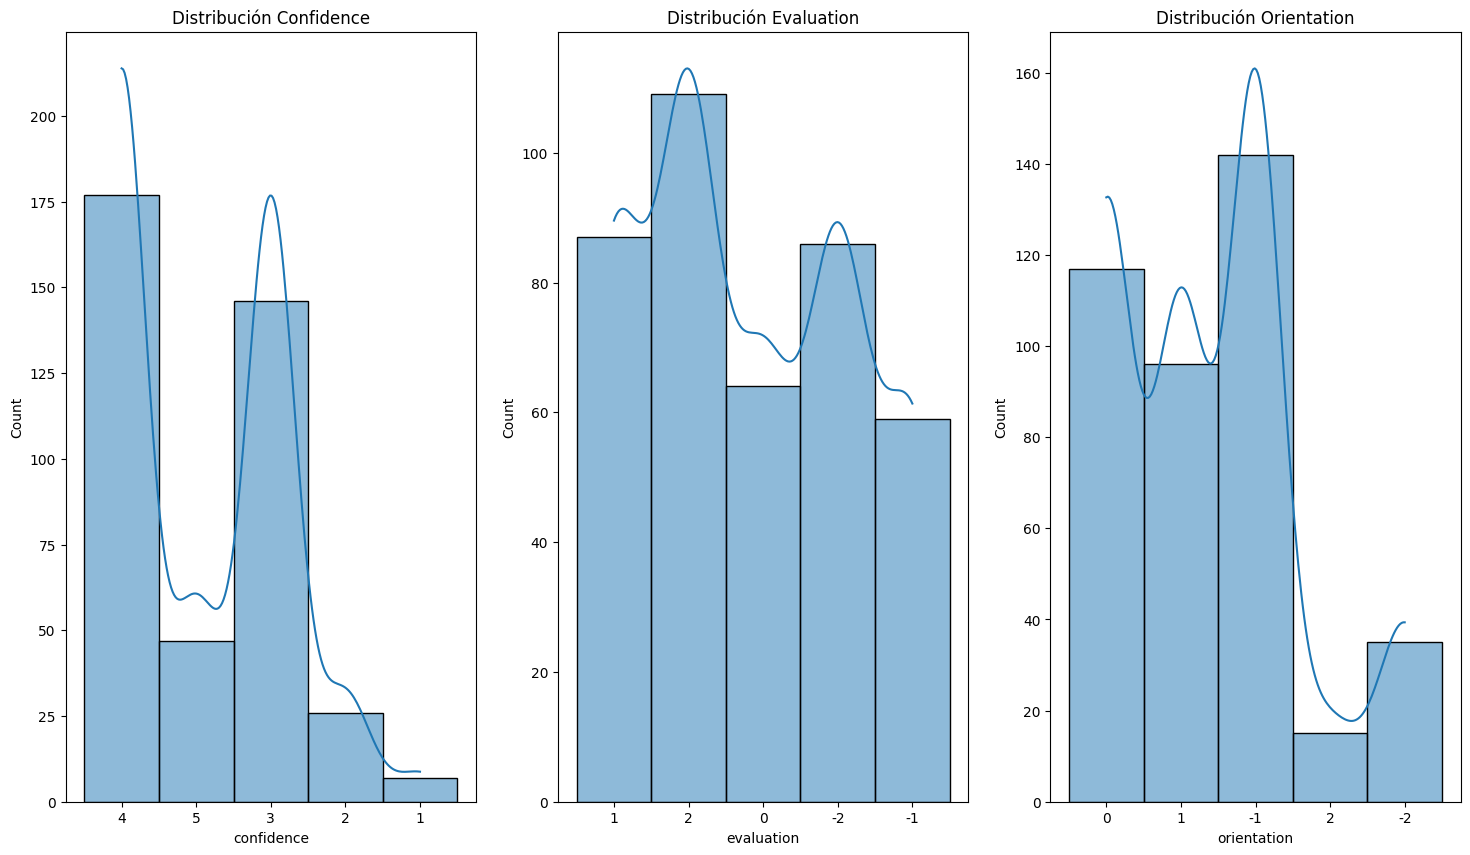

In [5]:
fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.histplot(data=df, x='confidence',  kde=True, ax = axs[0]).set(title='Distribución Confidence')
sns.histplot(data=df, x='evaluation',  kde=True, ax = axs[1]).set(title='Distribución Evaluation')
sns.histplot(data=df, x='orientation',  kde=True, ax = axs[2]).set(title='Distribución Orientation')

Con base a este analisis, primero que todo tomaremos información de texto unicamente en español y también consideraremos el campo de evaluación

Adicionalmente filtraremos registros con longitud del texto no núla, ya que existen campos vacios. 

In [6]:
idd = df.lan=='es'
df_filter = df.loc[idd].copy()
columns_ = ['text', 'evaluation']
df_filter = df_filter.loc[:,columns_]
idd = df_filter.text != ''
df_filter = df_filter.loc[idd]
del idd, columns_
print(df_filter.info())
df_filter.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 404
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        382 non-null    object
 1   evaluation  382 non-null    object
dtypes: object(2)
memory usage: 9.0+ KB
None


,text,evaluation
0,- El artículo aborda un problema contingente y...,1
1,El artículo presenta recomendaciones prácticas...,1
2,- El tema es muy interesante y puede ser de mu...,1
3,Se explica en forma ordenada y didáctica una e...,2
5,Los autores describen una metodología para des...,2


In [7]:
# Chequeo Final de la Longitud para tener texto con sentido.
df_filter.assign(len_ = df_filter.text.apply(len)).sort_values('len_')

,text,evaluation,len_
84,Me ha gustado mucho Lo dejaría tal cual.,2,41
31,"Un trabajo muy claro, preciso y del alto nivel",2,46
166,Los comentarios aparecen en el archivo adjunto,2,46
55,Poca información sobre aspectos técnicos utili...,0,81
183,-\tNo existen bases científicas explicitas en ...,-2,92
...,...,...,...
116,La publicación tiene como objetivo mostrar las...,1,4358
327,El artículo presenta una aplicación en el ámbi...,-2,4382
75,El trabajo es de baja calidad académica (descr...,-2,4535
264,"• Revisar los conceptos de metodologías, métod...",-1,4754


#### Train and test division

In [8]:
df_filter.to_csv('clean_reviews.csv', encoding='utf-8', sep='|')

In [9]:
class TextData(Dataset):
    '''
    Dataset basico para leer los datos de tweets
    '''
    def __init__(self, filename):
        super(TextData, self).__init__()
        df = pd.read_csv(filename,encoding='utf-8', sep='|')
        self.df = df[["evaluation", "text"]]
        
    def __getitem__(self, index):
        return self.df.iloc[index,0], self.df.iloc[index,1]
    
    def __len__(self):
        return len(self.df)

In [10]:
df = TextData("clean_reviews.csv")
train_dataset, test_dataset = random_split(df,
 [int(len(df)*0.7),len(df) - int(len(df)*0.7)], torch.manual_seed(1))

train_dataset, valid_dataset = random_split(
    list(train_dataset), [int(len(train_dataset)*0.8),len(train_dataset)-int(len(train_dataset)*0.8)], torch.manual_seed(1))

### 1.3 Preprocesamiento del texto

In [11]:
#funcion de limpieza de tweets

def tokenizacion(text):
  def limpieza(text):
    text=re.sub(r'@_[A-Za-z0-9]+_','',text) #Remover @_menciones_
    text=re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text) #Remover @menciones_
    text=re.sub(r'@[A-Za-z0-9]+','',text) #Remover @menciones
    text=re.sub(r'https?:\/\/\S+','',text) #Remover Hypervinculos
    text=re.sub(r'RT[\s]+','',text) #Remover Retweets
    text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
    text=re.sub(r'#[A-Za-z0-9]+','',text) #Remover "#"
    text=re.sub(r'[0-9]','',text) #remover numeros
    text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
    text=re.sub(r'\n|\t',' ',text) #remover saltos de linea
    text=re.sub(r'\@',' ',text) #remover "@"
    text=re.sub(r'[\s]+',' ',text) #reemplazar espacios dobles por espacion sencillos
    text=re.sub(r"^[\s]",' ',text) #eliminar espacios al inicio de cada tweet
    text=text.lower() #todo a minuscula
    return text
  
  text2=limpieza(text)

  #tokenizar tweet eliminando stopwords
  token1=word_tokenize(text2)
  token2=[]
  for word in token1:
    if word not in misstop: 
      token2.append(word)
  return token2

### 1.4 Creación del vocabulario y transformación de palabras a índices (y viceversa)

In [12]:
# Creación del vocabulario
token_counts = Counter()
for label, line in train_dataset:
    tokens = tokenizacion(line)
    token_counts.update(tokens)


print('Vocab-size:', len(token_counts))

Vocab-size: 4220


In [13]:
#token_counts

In [14]:
# indexando tokens
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab_ = vocab(ordered_dict)

vocab_.insert_token("", 0)
vocab_.set_default_index(1)

print([vocab_[token] for token in ['manejo', 'literatura', 'utliza', 'arte']])

[671, 121, 1, 135]


### 1.5 Creación del "dataset" y "dataloader" involucrando los pasos 2 y 3.

In [15]:
text_pipeline = lambda x: [vocab_[token] for token in tokenizacion(x)]
label_pipeline = lambda x: x +2 

#Definir funcion de trnasformacion y codificacion
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [16]:
## Toma un pequeño batch
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[   1,    5,  407, 1980,  135,  124,  408,  365, 1311,  286,   67, 1981,
          120,  970,   67, 1982,  752,  121,   73,  521,  753,  754,  755,  522,
          622,  155,   43,  756,   50,    1,  623,  287, 1312,   34,   68, 1313,
          122,  107,  135]])
tensor([0])
tensor([39])
torch.Size([1, 39])


In [17]:
batch_size = 50

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

### 1.6 Creación del modelo, involucrando embeddings.

In [18]:
num_classes=len(df_filter.evaluation.unique())
print(num_classes)

5


In [19]:
class RNN_GRU_BI(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        torch.manual_seed(0)
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.GRU(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
 

class RNN_LSTM_BI(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        torch.manual_seed(0)
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    


In [20]:
### Si funciona queda esta: 
import torch.nn.functional as F
def gru_training_validation(vocab_size = len(vocab_), embed_dim = 64,
                            rnn_hidden_size = 64,
                            fc_hidden_size = 64,
                            num_epochs = 500,
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_='adam',
                            loss_func = F.cross_entropy,
                            return_for_graphichs= False
                            ):
    model_gru = RNN_GRU_BI(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
    model_gru = model_gru.to(device)

    if optimizer_ == 'adam':
        optimizer = torch.optim.Adam(model_gru.parameters(), lr=lr)
    elif optimizer_ == 'SGD':
        optimizer = torch.optim.SGD(model_gru.parameters(), lr=lr)

    def train_GRU_BI(dataloader):
        model_gru.train()
        total_acc, total_loss = 0, 0
        losses,acc_acum,nums=0,0,0

        for text_batch, label_batch, lengths in dataloader:
            optimizer.zero_grad()
            y_test=label_batch.long()
            y_pred = torch.argmax(model_gru(text_batch, lengths), 1)

            pred = model_gru(text_batch, lengths)
            loss = loss_func(pred, y_test)
            loss.backward()
            optimizer.step()
    
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)

        return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

    def evaluate_GRU_BI(dataloader):
        model_gru.eval()
        total_acc, total_loss = 0, 0
        with torch.no_grad():
            for text_batch, label_batch, lengths in dataloader:
                #revisar funcion de perdida
                y_pred = torch.argmax(model_gru(text_batch, lengths), 1)
                y_test=label_batch.long()
                pred = model_gru(text_batch, lengths)
                loss = loss_func(pred, y_test)
                total_acc += (y_pred == label_batch).float().sum().item()
                total_loss += loss.item()*label_batch.size(0)
        return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
    
    #Entrenando modelo
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(num_epochs):
            acc_train, loss_train = train_GRU_BI(train_dl)
            acc_valid, loss_valid = evaluate_GRU_BI(valid_dl)
            train_losses.append(loss_train)
            valid_losses.append(loss_valid)
            train_acc.append(acc_train)
            valid_acc.append(acc_valid)
            #print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
            #valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")
    acc_test, _ = evaluate_GRU_BI(test_dl)
    print(f'test_accuracy: {acc_test:.4f}') 

    if return_for_graphichs:
        return acc_test, train_acc, valid_acc, model_gru
    else: 
        return acc_test    


In [35]:
### Funcion de validacion LSTM
import torch.nn.functional as F
def lstm_training_validation(vocab_size = len(vocab_), embed_dim = 64,
                            rnn_hidden_size = 64,
                            fc_hidden_size = 64,
                            num_epochs = 500,
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_='adam',
                            loss_func = F.cross_entropy,
                            return_for_graphichs= False
                            ):
    model_lstm = RNN_LSTM_BI(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
    model_lstm = model_lstm.to(device)

    if optimizer_ == 'adam':
        optimizer = torch.optim.Adam(model_lstm.parameters(), lr=lr)
    elif optimizer_ == 'SGD':
        optimizer = torch.optim.SGD(model_lstm.parameters(), lr=lr)

    def train_LSTM_BI(dataloader):
        model_lstm.train()
        total_acc, total_loss = 0, 0
        losses,acc_acum,nums=0,0,0

        for text_batch, label_batch, lengths in dataloader:
            optimizer.zero_grad()
            y_test=label_batch.long()
            y_pred = torch.argmax(model_lstm(text_batch, lengths), 1)

            pred = model_lstm(text_batch, lengths)
            loss = loss_func(pred, y_test)
            loss.backward()
            optimizer.step()
    
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)

        return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

    def evaluate_LSTM_BI(dataloader):
        model_lstm.eval()
        total_acc, total_loss = 0, 0
        with torch.no_grad():
            for text_batch, label_batch, lengths in dataloader:
                #revisar funcion de perdida
                y_pred = torch.argmax(model_lstm(text_batch, lengths), 1)
                y_test=label_batch.long()
                pred = model_lstm(text_batch, lengths)
                loss = loss_func(pred, y_test)
                total_acc += (y_pred == label_batch).float().sum().item()
                total_loss += loss.item()*label_batch.size(0)
        return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
    
    #Entrenando modelo
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []


    for epoch in range(num_epochs):
            acc_train, loss_train = train_LSTM_BI(train_dl)
            acc_valid, loss_valid = evaluate_LSTM_BI(valid_dl)
            train_losses.append(loss_train)
            valid_losses.append(loss_valid)
            train_acc.append(acc_train)
            valid_acc.append(acc_valid)
            #print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
            #valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")
    acc_test, _ = evaluate_LSTM_BI(test_dl)
    print(f'test_accuracy: {acc_test:.4f}') 
    
    if return_for_graphichs:
        return acc_test, train_acc, valid_acc, model_lstm
    else: 
        return acc_test    
    
    return acc_test
    print('hola')


In [22]:
### Corriendo validaciones
params_ = {'optimizer_': ['adam', 'SGD'],
            'NUM_HIDDEN': [10,20,30],
            'epochs': [10,25, 50,100], 
            'loss_func': [F.cross_entropy]}

In [23]:
%%time
from itertools import product
param_names = list(params_.keys())
# zip with parameter names in order to get original property
param_values = (zip(param_names, x) for x in product(*params_.values()))

result_val_acc = list()
output = pd.DataFrame()
for paramset in param_values:
    # use the dict from iterator of tuples constructor
    dict_temp = dict(paramset)
    output = output.append(dict_temp, ignore_index=True)
    # operando la grilla para tener el accuracy y guardar en lista

    result_val_acc.append(gru_training_validation(vocab_size = len(vocab_), embed_dim = dict_temp['NUM_HIDDEN'],
                            rnn_hidden_size = dict_temp['NUM_HIDDEN'],
                            fc_hidden_size = dict_temp['NUM_HIDDEN'],
                            num_epochs = dict_temp['epochs'],
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_=dict_temp['optimizer_'],
                            loss_func = dict_temp['loss_func']
                            ))

test_accuracy: 0.2435
test_accuracy: 0.2261
test_accuracy: 0.3304
test_accuracy: 0.2087
test_accuracy: 0.2348
test_accuracy: 0.2348
test_accuracy: 0.1826
test_accuracy: 0.1826
test_accuracy: 0.2609
test_accuracy: 0.2957
test_accuracy: 0.2696
test_accuracy: 0.2522
test_accuracy: 0.1391
test_accuracy: 0.1391
test_accuracy: 0.1391
test_accuracy: 0.1304
test_accuracy: 0.1304
test_accuracy: 0.1391
test_accuracy: 0.1304
test_accuracy: 0.1304
test_accuracy: 0.2348
test_accuracy: 0.2348
test_accuracy: 0.2522
test_accuracy: 0.2435
CPU times: user 18min 52s, sys: 8min 58s, total: 27min 50s
Wall time: 17min 50s


In [24]:
output = output.assign(acc_val = result_val_acc)
print('MEJOR COMBINACIÓN DE Parametros para el modelo GRU ')
best_params_GRU = output.loc[output.acc_val == output.acc_val.max()].reset_index()
best_params_GRU

MEJOR COMBINACIÓN DE Parametros para el modelo GRU 


,index,optimizer_,NUM_HIDDEN,epochs,loss_func,acc_val
0,2,adam,10,50,<function cross_entropy at 0x11fc42ee0>,0.330435


In [32]:
%%time
## agregamos el de LSTM
from itertools import product
param_names = list(params_.keys())
# zip with parameter names in order to get original property
param_values = (zip(param_names, x) for x in product(*params_.values()))

result_val_acc = list()
output_LSTM = pd.DataFrame()
for paramset in param_values:
    # use the dict from iterator of tuples constructor
    dict_temp = dict(paramset)
    output_LSTM = output_LSTM.append(dict_temp, ignore_index=True)
    # operando la grilla para tener el accuracy y guardar en lista

    result_val_acc.append(lstm_training_validation(vocab_size = len(vocab_), embed_dim = dict_temp['NUM_HIDDEN'],
                            rnn_hidden_size = dict_temp['NUM_HIDDEN'],
                            fc_hidden_size = dict_temp['NUM_HIDDEN'],
                            num_epochs = dict_temp['epochs'],
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_=dict_temp['optimizer_'],
                            loss_func = dict_temp['loss_func']
                            ))

test_accuracy: 0.2522
test_accuracy: 0.2783
test_accuracy: 0.2261
test_accuracy: 0.2522
test_accuracy: 0.2609
test_accuracy: 0.2261
test_accuracy: 0.2087
test_accuracy: 0.2087
test_accuracy: 0.2261
test_accuracy: 0.2261
test_accuracy: 0.2174
test_accuracy: 0.2783
test_accuracy: 0.2522
test_accuracy: 0.2522
test_accuracy: 0.2522
test_accuracy: 0.2522
test_accuracy: 0.2261
test_accuracy: 0.2261
test_accuracy: 0.2261
test_accuracy: 0.2174
test_accuracy: 0.2348
test_accuracy: 0.2348
test_accuracy: 0.2348
test_accuracy: 0.2348
CPU times: user 22min 5s, sys: 15min 24s, total: 37min 29s
Wall time: 20min 34s


In [33]:
output_LSTM = output_LSTM.assign(acc_val = result_val_acc)
print('MEJOR COMBINACIÓN DE Parametros para el modelo LSTM')
output_LSTM = output_LSTM.loc[output_LSTM.acc_val == output_LSTM.acc_val.max()].reset_index()
output_LSTM

MEJOR COMBINACIÓN DE Parametros para el modelo LSTM


,index,optimizer_,NUM_HIDDEN,epochs,loss_func,acc_val
0,1,adam,10,25,<function cross_entropy at 0x11fc42ee0>,0.278261
1,11,adam,30,100,<function cross_entropy at 0x11fc42ee0>,0.278261


Con base en el analisis previo construido, nos quedamos con un modelo bajo las siguientes condiciones: 

- optimizer: SGD
- Num_hidden: 10
- epochs: 75
- LOss_function: Cross Entropy

In [27]:
acc_test, train_acc, valid_acc, model_gru=  gru_training_validation(vocab_size = len(vocab_), embed_dim =10,# best_params['NUM_HIDDEN'][0],
                            rnn_hidden_size = 10,#best_params['NUM_HIDDEN'][0],
                            fc_hidden_size = 10,#best_params['NUM_HIDDEN'][0],
                            num_epochs =50,# best_params['epochs'][0],
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_='adam',#best_params['optimizer_'][0],
                            loss_func = F.cross_entropy,#best_params['loss_func'][0],
                            return_for_graphichs= True
                            )

test_accuracy: 0.3304


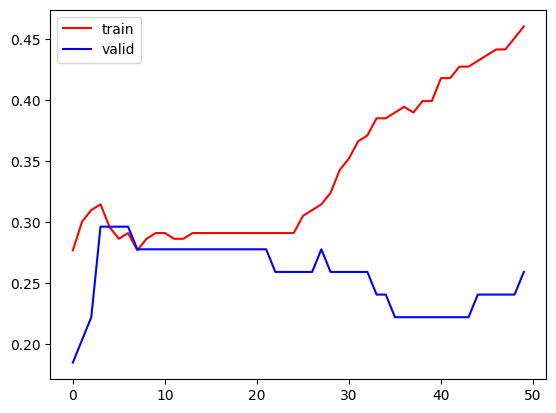

In [28]:
plt.plot(range(len(train_acc)), train_acc, 'r', label='train')
plt.plot(range(len(train_acc)), valid_acc, 'b', label = 'valid')
plt.legend()

In [29]:
model_gru.eval()

RNN_GRU_BI(
  (embedding): Embedding(4221, 10, padding_idx=0)
  (rnn): GRU(10, 10, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

In [30]:
model_gru.state_dict()

OrderedDict([('embedding.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.3632,  0.3040,  0.1791,  ..., -1.7606,  0.6179,  0.8061],
                      [ 0.7254, -1.6484, -0.4206,  ...,  0.0746,  1.3232,  1.7171],
                      ...,
                      [-0.3435, -0.3522,  0.8941,  ...,  0.9178,  2.0695,  0.7487],
                      [-0.1810,  1.6964, -0.3767,  ..., -0.5316, -1.1233,  0.9177],
                      [ 0.2410,  0.6598,  0.5577,  ...,  0.6855, -1.1125,  3.2602]])),
             ('rnn.weight_ih_l0',
              tensor([[-6.6944e-03, -1.9337e-01, -3.8909e-01, -2.1673e-01, -1.8606e-01,
                       -1.3828e-01,  4.6237e-01,  1.6642e-01, -5.3326e-02,  2.4816e-01],
                      [ 5.1029e-02,  2.2157e-01,  2.6994e-01, -2.8742e-01, -4.3374e-02,
                        3.3735e-01, -7.3035e-02,  2.0079e-01, -2.9365e-01,  1.4259e-01],
                      [-2.5289e-01,  2.7307e

In [36]:
acc_test, train_acc, valid_acc, model_lstm=  lstm_training_validation(vocab_size = len(vocab_), embed_dim =10,# best_params['NUM_HIDDEN'][0],
                            rnn_hidden_size = 10,#best_params['NUM_HIDDEN'][0],
                            fc_hidden_size = 10,#best_params['NUM_HIDDEN'][0],
                            num_epochs =50,# best_params['epochs'][0],
                            lr=0.001,
                            num_classes=len(df_filter.evaluation.unique()),
                            device = device,
                            optimizer_='adam',#best_params['optimizer_'][0],
                            loss_func = F.cross_entropy,#best_params['loss_func'][0],
                            return_for_graphichs= True
                            )

test_accuracy: 0.2261


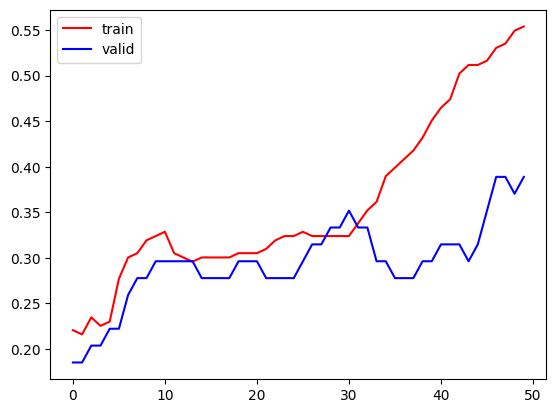

In [37]:
plt.plot(range(len(train_acc)), train_acc, 'r', label='train')
plt.plot(range(len(train_acc)), valid_acc, 'b', label = 'valid')
plt.legend()

In [38]:
model_lstm.eval()

RNN_LSTM_BI(
  (embedding): Embedding(4221, 10, padding_idx=0)
  (rnn): LSTM(10, 10, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

#### Guardar el modelo

In [31]:
## save current model
torch.save(model_gru, 'model_gru_ex_1.pt')
## save weight
torch.save(model_gru.state_dict, 'model_gru_ex_1_state_dict')

In [39]:
## save current model
torch.save(model_lstm, 'model_lstm_ex_1.pt')
## save weight
torch.save(model_lstm.state_dict, 'model_lstm_ex_1_state_dict')

**Nota**

Para continuar pasaremos a un notebook en colab para el proceso de disponibilización 

## Parte 2. Convirtiendo el texto a un problema de clasificación por palabras o frases (NER)

## Parte 2 A. Etiquetado 
Etiquetado de los comentarios frases a frases
Usando herramientas como [brat](https://brat.nlplab.org/), [docanno](https://doccano.herokuapp.com/) o [inception](https://inception-project.github.io/) (ver [este blog](https://dida.do/blog/the-best-free-labeling-tools-for-text-annotation-in-nlp) para un rápido resumen sobre estas aplicaciones), deberán etiquetar las frases en los comentarios con las etiquetas que correspondan a cada categoría. Un ejemplo para el primer comentario lo muestra la siguiente figura: 
![image](ejemploetiquetado.png)

Nota: El anterior ejemplo lo hice en la herramienta de inception (y exportando el archivo a WebAnno TSV v3.3).
Como pueden observar la mayoría de palabras no se etiquetarán (pertenecen a una categoría como "otros").

No deben etiquetar todo el dataset, pueden hacerlo con unas 100 (por grupo). Pero pueden intercambiarse (entre grupos que les haya tocado el mismo trabajo) los datasets etiquetados para incrementar el número de datos (para esto es recomendable usar la misma herramienta y el mismo tipo de archivo de exportación).

### Parte 2. Clasificación y localización de las frases
Cree un modelo de clasificación por palabra (es similar al punto 2 del taller 4), donde involucren redes recurrentes. Cuando varias palabras contiguas pertenezcan a la misma etiqueta deberan unirlas para etiquetarlas como frase.  Para este modelo deben seguir los mismos pasos de la parte 1, pero cambiando un poco el modelo. 

- Desarrolle un modelo inicializando los pesos de forma aleatoria (por defecto)
- Desarrolle un modelo partiendo de los pesos de la parte 1.
- Desarrolle un modelo word2vec y posteriormente cargue estos pesos en la capa de embedding para desarrollar el modelo recurrente.Les puede ser útil [esto](https://gist.github.com/dhruvdcoder/cbb8d7967a499ba85418c18414e2cdce).
- Compare los modelos anteriores.
- Visualice la clasificación de algunas frases del conjunto de validación usando spacy o la herramienta que usaron para etiquetar.

-----
Es importante que realicen gráficos y visualizaciones que ayuden a la interpretación. No olviden ir analizando y comentando los hallazgos, y sobretodo **concluir**. El entregable es un notebook de Jupyter, debidamente presentado y comentado.

- ¿Qué diferencian encuentran con un tipo de clasificación respecto al otro?
- ¿Los pesos de una tarea ayudan a la otra?
- ¿Es posible analizar o intuir a partir de pesos o activaciones, que parte del texto está ayudando en la parte 1 a clasificar?

### Tip de lectura de datos del archivo JSON

In [ ]:
import pandas as pd

In [ ]:
import json
# load data using Python JSON module
with open('reviews.json','r') as f:
    data = json.loads(f.read())

In [ ]:
df = pd.json_normalize(data['paper'], record_path = ["review"])
df.head()

,confidence,evaluation,id,lan,orientation,remarks,text,timespan
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05
3,4,2,1,es,1,,Se explica en forma ordenada y didáctica una e...,2010-07-05
4,4,2,2,es,0,,,2010-07-05
